# DDoS Attack Multi-Class Classification (Weighted Loss) - V2

This notebook handles **class imbalance** using weighted loss functions.

**Models:**
- Deep & Cross Network (DCN) - GPU accelerated, **weighted CrossEntropyLoss**
- Tabular Transformer - GPU accelerated, **weighted CrossEntropyLoss**
- AdaBoost - **class_weight='balanced'**
- Logistic Regression - **class_weight='balanced'**

**Classes (12):** Benign, DNS, LDAP, MSSQL, NTP, NetBIOS, Portmap, SNMP, Syn, TFTP, UDP, UDPLag

## 1. Imports and Configuration

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
import joblib
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
Number of GPUs: 2


In [2]:
# ============================================
# CONFIGURATION
# ============================================

RANDOM_STATE = 42

# Kaggle paths
DATA_PATH = '/kaggle/input/ddos-dataset-v2'
OUTPUT_DIR = '/kaggle/working'

# Model saving
SAVE_MODELS = True
MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')

# Validation split
VAL_SIZE = 0.2

# Deep learning hyperparameters
DCN_EPOCHS = 15
TRANSFORMER_EPOCHS = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 512

# Number of classes
N_CLASSES = 12

# Class labels
CLASS_LABELS = ['Benign', 'DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 
                'Portmap', 'SNMP', 'Syn', 'TFTP', 'UDP', 'UDPLag']

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0

print(f"Device: {device}")
print(f"Number of GPUs: {n_gpus}")

# Create model directory
if SAVE_MODELS:
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Models will be saved to: {MODEL_DIR}")

Device: cuda
Number of GPUs: 2
Models will be saved to: /kaggle/working/models


## 2. Load Data

In [3]:
# Load datasets
print("Loading datasets...")

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
features_df = pd.read_csv(os.path.join(DATA_PATH, 'features.csv'))
label_mapping = pd.read_csv(os.path.join(DATA_PATH, 'label_mapping.csv'))

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Number of features to use: {len(features_df)}")

Loading datasets...
Train shape: (345056, 54)
Test shape: (86264, 54)
Number of features to use: 52


In [4]:
# Display label mapping
print("Label Mapping:")
print(label_mapping)

Label Mapping:
    encoded    label
0         0   Benign
1         1      DNS
2         2     LDAP
3         3    MSSQL
4         4      NTP
5         5  NetBIOS
6         6  Portmap
7         7     SNMP
8         8      Syn
9         9     TFTP
10       10      UDP
11       11   UDPLag


In [5]:
# Get feature names from features.csv
feature_names = features_df['feature'].tolist()
n_features = len(feature_names)

print(f"Number of features: {n_features}")
print(f"\nFeatures:")
print(feature_names)

Number of features: 52

Features:
['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Avg Packet Size', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes', 'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', '

In [6]:
# Extract features and labels
X_train_full = train_df[feature_names].values
y_train_full = train_df['label_encoded'].values

X_test = test_df[feature_names].values
y_test = test_df['label_encoded'].values

print(f"X_train_full shape: {X_train_full.shape}")
print(f"X_test shape: {X_test.shape}")

X_train_full shape: (345056, 52)
X_test shape: (86264, 52)


In [7]:
# Split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_train_full  # Maintain class distribution
)

print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print(f"Test samples: {len(y_test):,}")

Training samples: 276,044
Validation samples: 69,012
Test samples: 86,264


In [8]:
# Class distribution
print("Training set class distribution:")
print("="*50)
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    bar = '#' * int(c / max(counts) * 30)
    print(f"  {CLASS_LABELS[u]:<10}: {c:>6,} ({c/len(y_train)*100:>5.2f}%) {bar}")

print(f"\nImbalance ratio (max/min): {max(counts)/max(min(counts), 1):.1f}x")

Training set class distribution:
  Benign    : 62,612 (22.68%) ########################
  DNS       :  2,348 ( 0.85%) 
  LDAP      :  2,142 ( 0.78%) 
  MSSQL     :  9,430 ( 3.42%) ###
  NTP       : 77,675 (28.14%) ##############################
  NetBIOS   :    795 ( 0.29%) 
  Portmap   :    439 ( 0.16%) 
  SNMP      :  1,739 ( 0.63%) 
  Syn       : 31,598 (11.45%) ############
  TFTP      : 63,307 (22.93%) ########################
  UDP       : 18,246 ( 6.61%) #######
  UDPLag    :  5,713 ( 2.07%) ##

Imbalance ratio (max/min): 176.9x


## 3. Data Preprocessing - Scaling

**Scaling is required for:**
- Logistic Regression (gradient-based optimizer)
- DCN (neural network)
- Tabular Transformer (neural network)

**Scaling is NOT required for:**
- AdaBoost (tree-based, invariant to scaling)

In [9]:
# Initialize and fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Keep unscaled versions for AdaBoost
X_train_unscaled = X_train
X_val_unscaled = X_val
X_test_unscaled = X_test

print("Scaling complete!")
print(f"Scaled data - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Unscaled data - Mean: {X_train_unscaled.mean():.2f}, Std: {X_train_unscaled.std():.2f}")

Scaling complete!
Scaled data - Mean: -0.000000, Std: 1.000000
Unscaled data - Mean: -2012908.83, Std: 601467885.70


In [10]:
# Save scaler for later use
if SAVE_MODELS:
    scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to: {scaler_path}")

Scaler saved to: /kaggle/working/models/scaler.joblib


## 4. Calculate Class Weights

Formula: `weight[class] = total_samples / (n_classes * class_count)`

In [11]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_counts_array = np.bincount(y_train)

print("Class Weights (for handling imbalance):")
print("="*60)
for i, (label, weight, count) in enumerate(zip(CLASS_LABELS, class_weights, class_counts_array)):
    print(f"  {label:<10}: weight={weight:>8.4f}  (samples: {count:>6,})")

print(f"\nWeight range: {class_weights.min():.4f} to {class_weights.max():.4f}")

Class Weights (for handling imbalance):
  Benign    : weight=  0.3674  (samples: 62,612)
  DNS       : weight=  9.7971  (samples:  2,348)
  LDAP      : weight= 10.7393  (samples:  2,142)
  MSSQL     : weight=  2.4394  (samples:  9,430)
  NTP       : weight=  0.2962  (samples: 77,675)
  NetBIOS   : weight= 28.9354  (samples:    795)
  Portmap   : weight= 52.4002  (samples:    439)
  SNMP      : weight= 13.2281  (samples:  1,739)
  Syn       : weight=  0.7280  (samples: 31,598)
  TFTP      : weight=  0.3634  (samples: 63,307)
  UDP       : weight=  1.2608  (samples: 18,246)
  UDPLag    : weight=  4.0265  (samples:  5,713)

Weight range: 0.2962 to 52.4002


In [12]:
# Convert class weights to PyTorch tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"Class weights tensor shape: {class_weights_tensor.shape}")
print(f"Class weights tensor device: {class_weights_tensor.device}")

Class weights tensor shape: torch.Size([12])
Class weights tensor device: cuda:0


## 5. Prepare PyTorch DataLoaders

In [13]:
# Convert to PyTorch tensors (scaled data for neural networks)
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")

X_train_tensor shape: torch.Size([276044, 52])
X_val_tensor shape: torch.Size([69012, 52])
X_test_tensor shape: torch.Size([86264, 52])


In [14]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    pin_memory=True if device.type == 'cuda' else False,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    pin_memory=True if device.type == 'cuda' else False,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    pin_memory=True if device.type == 'cuda' else False,
    num_workers=2
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 540
Validation batches: 135
Test batches: 169


## 6. Evaluation Utilities

In [15]:
# Dictionary to store all model results
model_results = {}

def evaluate_model(y_true, y_pred, y_prob, model_name, training_time=None):
    """Calculate and return all metrics for a multi-class model."""
    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_pred': y_pred,
        'y_prob': y_prob,
        'training_time': training_time
    }
    
    # ROC-AUC for multi-class (one-vs-rest)
    try:
        results['roc_auc_ovr'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    except:
        results['roc_auc_ovr'] = None
    
    return results

def print_metrics(results, model_name):
    """Print formatted metrics."""
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    print(f"Accuracy:           {results['accuracy']:.4f}")
    print(f"Precision (macro):  {results['precision_macro']:.4f}")
    print(f"Precision (weighted): {results['precision_weighted']:.4f}")
    print(f"Recall (macro):     {results['recall_macro']:.4f}")
    print(f"Recall (weighted):  {results['recall_weighted']:.4f}")
    print(f"F1-Score (macro):   {results['f1_macro']:.4f}")
    print(f"F1-Score (weighted): {results['f1_weighted']:.4f}")
    if results['roc_auc_ovr'] is not None:
        print(f"ROC-AUC (OvR):      {results['roc_auc_ovr']:.4f}")
    if results['training_time']:
        print(f"Training Time:      {results['training_time']:.2f} seconds")

print("Evaluation utilities defined.")

Evaluation utilities defined.


## 7. Model 1: Logistic Regression (Weighted)

Uses `class_weight='balanced'` and **scaled data**.

In [16]:
print("Training Logistic Regression with class_weight='balanced'...")
print("Using SCALED data")
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    solver='lbfgs',
    multi_class='multinomial',
    class_weight='balanced'
)
lr_model.fit(X_train_scaled, y_train)

lr_train_time = time.time() - start_time

# Predictions on test set
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)

# Evaluate
lr_results = evaluate_model(y_test, lr_pred, lr_prob, 'Logistic Regression', lr_train_time)
model_results['Logistic Regression'] = lr_results

# Print results
print_metrics(lr_results, 'Logistic Regression (Weighted)')

# Save model
if SAVE_MODELS:
    lr_path = os.path.join(MODEL_DIR, 'logistic_regression.joblib')
    joblib.dump(lr_model, lr_path)
    print(f"\nModel saved: {lr_path}")

Training Logistic Regression with class_weight='balanced'...
Using SCALED data


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression (Weighted) Results
Accuracy:           0.9487
Precision (macro):  0.6697
Precision (weighted): 0.9558
Recall (macro):     0.7327
Recall (weighted):  0.9487
F1-Score (macro):   0.6834
F1-Score (weighted): 0.9509
ROC-AUC (OvR):      0.9880
Training Time:      115.03 seconds

Model saved: /kaggle/working/models/logistic_regression.joblib


## 8. Model 2: AdaBoost (Weighted)

Uses weighted DecisionTree base estimator and **unscaled data** (tree-based).

In [17]:
print("Training AdaBoost with weighted base estimator...")
print("Using UNSCALED data (tree-based model)")
start_time = time.time()

base_estimator = DecisionTreeClassifier(
    max_depth=3,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    algorithm='SAMME'
)
ada_model.fit(X_train_unscaled, y_train)

ada_train_time = time.time() - start_time

# Predictions on test set (unscaled)
ada_pred = ada_model.predict(X_test_unscaled)
ada_prob = ada_model.predict_proba(X_test_unscaled)

# Evaluate
ada_results = evaluate_model(y_test, ada_pred, ada_prob, 'AdaBoost', ada_train_time)
model_results['AdaBoost'] = ada_results

# Print results
print_metrics(ada_results, 'AdaBoost (Weighted)')

# Save model
if SAVE_MODELS:
    ada_path = os.path.join(MODEL_DIR, 'adaboost.joblib')
    joblib.dump(ada_model, ada_path)
    print(f"\nModel saved: {ada_path}")

Training AdaBoost with weighted base estimator...
Using UNSCALED data (tree-based model)

AdaBoost (Weighted) Results
Accuracy:           0.9473
Precision (macro):  0.6824
Precision (weighted): 0.9601
Recall (macro):     0.7360
Recall (weighted):  0.9473
F1-Score (macro):   0.6810
F1-Score (weighted): 0.9518
ROC-AUC (OvR):      0.9819
Training Time:      21.53 seconds

Model saved: /kaggle/working/models/adaboost.joblib


## 9. Model 3: Deep & Cross Network (Weighted Loss)

Uses **weighted CrossEntropyLoss** and **scaled data**.

In [18]:
class DCN(nn.Module):
    """Deep & Cross Network for multi-class tabular data."""
    
    def __init__(self, n_features, n_classes, n_cross_layers=3, deep_layers=[128, 64, 32], dropout=0.1):
        super(DCN, self).__init__()
        
        self.n_features = n_features
        self.n_cross_layers = n_cross_layers
        
        # Cross Network - explicit feature interactions
        self.cross_weights = nn.ParameterList([
            nn.Parameter(torch.randn(n_features, 1) * 0.01)
            for _ in range(n_cross_layers)
        ])
        self.cross_biases = nn.ParameterList([
            nn.Parameter(torch.zeros(n_features))
            for _ in range(n_cross_layers)
        ])
        
        # Deep Network
        deep_input_dim = n_features
        self.deep_layers = nn.ModuleList()
        for hidden_dim in deep_layers:
            self.deep_layers.append(nn.Linear(deep_input_dim, hidden_dim))
            deep_input_dim = hidden_dim
        
        self.dropout = nn.Dropout(dropout)
        
        # Output layer: combine cross and deep outputs
        final_dim = n_features + deep_layers[-1]
        self.output = nn.Linear(final_dim, n_classes)
    
    def cross_layer(self, x0, xl, w, b):
        """Single cross layer: x_{l+1} = x0 * (xl^T * w) + b + xl"""
        xlw = torch.mm(xl, w)
        cross = x0 * xlw + b + xl
        return cross
    
    def forward(self, x):
        # Cross Network
        x0 = x
        xl = x
        for i in range(self.n_cross_layers):
            xl = self.cross_layer(x0, xl, self.cross_weights[i], self.cross_biases[i])
        cross_out = xl
        
        # Deep Network
        deep_out = x
        for layer in self.deep_layers:
            deep_out = F.relu(layer(deep_out))
            deep_out = self.dropout(deep_out)
        
        # Combine
        combined = torch.cat([cross_out, deep_out], dim=1)
        out = self.output(combined)
        return out

print("DCN architecture defined.")

DCN architecture defined.


In [19]:
print(f"Training DCN for {DCN_EPOCHS} epochs on {device}...")
print(f"Using SCALED data and WEIGHTED CrossEntropyLoss")
if n_gpus > 1:
    print(f"Using DataParallel with {n_gpus} GPUs")

start_time = time.time()

# Initialize model
dcn_model = DCN(
    n_features=n_features,
    n_classes=N_CLASSES,
    n_cross_layers=3,
    deep_layers=[128, 64, 32],
    dropout=0.1
).to(device)

# Wrap with DataParallel for multi-GPU
if n_gpus > 1:
    dcn_model = nn.DataParallel(dcn_model)

# Weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(dcn_model.parameters(), lr=LEARNING_RATE)

# Training loop with validation
dcn_model.train()
dcn_train_losses = []
dcn_val_losses = []

for epoch in range(DCN_EPOCHS):
    # Training
    dcn_model.train()
    epoch_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = dcn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_train_loss = epoch_loss / n_batches
    dcn_train_losses.append(avg_train_loss)
    
    # Validation
    dcn_model.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            outputs = dcn_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    dcn_val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 3 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1}/{DCN_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

dcn_train_time = time.time() - start_time

# Evaluation on test set
dcn_model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device, non_blocking=True)
        outputs = dcn_model(X_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

dcn_prob = torch.cat(all_probs).numpy()
dcn_pred = torch.cat(all_preds).numpy()

# Clear GPU cache
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Evaluate
dcn_results = evaluate_model(y_test, dcn_pred, dcn_prob, 'DCN', dcn_train_time)
model_results['DCN'] = dcn_results

# Print results
print_metrics(dcn_results, 'DCN (Weighted Loss)')

# Save model
if SAVE_MODELS:
    model_to_save = dcn_model.module if isinstance(dcn_model, nn.DataParallel) else dcn_model
    dcn_path = os.path.join(MODEL_DIR, 'dcn.pt')
    torch.save({
        'model_state_dict': model_to_save.state_dict(),
        'n_features': n_features,
        'n_classes': N_CLASSES,
        'epochs': DCN_EPOCHS
    }, dcn_path)
    print(f"\nModel saved: {dcn_path}")

Training DCN for 15 epochs on cuda...
Using SCALED data and WEIGHTED CrossEntropyLoss
Using DataParallel with 2 GPUs
  Epoch 1/15, Train Loss: 4.0189, Val Loss: 0.8310
  Epoch 3/15, Train Loss: 0.8269, Val Loss: 0.6912
  Epoch 6/15, Train Loss: 1.0015, Val Loss: 1.0219
  Epoch 9/15, Train Loss: 0.9487, Val Loss: 0.6703
  Epoch 12/15, Train Loss: 0.6267, Val Loss: 0.6200
  Epoch 15/15, Train Loss: 1.3830, Val Loss: 12.1044

DCN (Weighted Loss) Results
Accuracy:           0.9628
Precision (macro):  0.7095
Precision (weighted): 0.9651
Recall (macro):     0.7539
Recall (weighted):  0.9628
F1-Score (macro):   0.7120
F1-Score (weighted): 0.9627
ROC-AUC (OvR):      0.9946
Training Time:      77.34 seconds

Model saved: /kaggle/working/models/dcn.pt


## 10. Model 4: Tabular Transformer (Weighted Loss)

Uses **weighted CrossEntropyLoss** and **scaled data**.

In [20]:
class TabularTransformer(nn.Module):
    """Transformer for multi-class tabular data."""
    
    def __init__(self, n_features, n_classes, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TabularTransformer, self).__init__()
        
        self.n_features = n_features
        self.d_model = d_model
        
        # Embed each feature value into d_model dimensions
        self.feature_embedding = nn.Linear(1, d_model)
        
        # Learnable positional encoding for each feature position
        self.pos_encoding = nn.Parameter(torch.randn(1, n_features, d_model) * 0.01)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers - multi-class
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_features * d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.feature_embedding(x)
        x = x + self.pos_encoding
        x = self.transformer_encoder(x)
        out = self.classifier(x)
        return out

print("Tabular Transformer architecture defined.")

Tabular Transformer architecture defined.


In [21]:
print(f"Training Tabular Transformer for {TRANSFORMER_EPOCHS} epochs on {device}...")
print(f"Using SCALED data and WEIGHTED CrossEntropyLoss")
if n_gpus > 1:
    print(f"Using DataParallel with {n_gpus} GPUs")

start_time = time.time()

# Initialize model
transformer_model = TabularTransformer(
    n_features=n_features,
    n_classes=N_CLASSES,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1
).to(device)

# Wrap with DataParallel for multi-GPU
if n_gpus > 1:
    transformer_model = nn.DataParallel(transformer_model)

# Weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE)

# Training loop with validation
transformer_model.train()
transformer_train_losses = []
transformer_val_losses = []

for epoch in range(TRANSFORMER_EPOCHS):
    # Training
    transformer_model.train()
    epoch_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = transformer_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_train_loss = epoch_loss / n_batches
    transformer_train_losses.append(avg_train_loss)
    
    # Validation
    transformer_model.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            outputs = transformer_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    transformer_val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 3 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1}/{TRANSFORMER_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

transformer_train_time = time.time() - start_time

# Evaluation on test set
transformer_model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device, non_blocking=True)
        outputs = transformer_model(X_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

transformer_prob = torch.cat(all_probs).numpy()
transformer_pred = torch.cat(all_preds).numpy()

# Clear GPU cache
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Evaluate
transformer_results = evaluate_model(y_test, transformer_pred, transformer_prob, 'Transformer', transformer_train_time)
model_results['Transformer'] = transformer_results

# Print results
print_metrics(transformer_results, 'Tabular Transformer (Weighted Loss)')

# Save model
if SAVE_MODELS:
    model_to_save = transformer_model.module if isinstance(transformer_model, nn.DataParallel) else transformer_model
    transformer_path = os.path.join(MODEL_DIR, 'transformer.pt')
    torch.save({
        'model_state_dict': model_to_save.state_dict(),
        'n_features': n_features,
        'n_classes': N_CLASSES,
        'epochs': TRANSFORMER_EPOCHS
    }, transformer_path)
    print(f"\nModel saved: {transformer_path}")

Training Tabular Transformer for 15 epochs on cuda...
Using SCALED data and WEIGHTED CrossEntropyLoss
Using DataParallel with 2 GPUs
  Epoch 1/15, Train Loss: 0.8313, Val Loss: 0.6440
  Epoch 3/15, Train Loss: 0.6349, Val Loss: 0.6424
  Epoch 6/15, Train Loss: 0.6063, Val Loss: 0.6007
  Epoch 9/15, Train Loss: 0.5813, Val Loss: 0.5754
  Epoch 12/15, Train Loss: 0.5782, Val Loss: 0.5887
  Epoch 15/15, Train Loss: 0.5667, Val Loss: 0.5798

Tabular Transformer (Weighted Loss) Results
Accuracy:           0.9664
Precision (macro):  0.7266
Precision (weighted): 0.9702
Recall (macro):     0.7709
Recall (weighted):  0.9664
F1-Score (macro):   0.7376
F1-Score (weighted): 0.9675
ROC-AUC (OvR):      0.9951
Training Time:      155.39 seconds

Model saved: /kaggle/working/models/transformer.pt


## 11. Training Loss Curves

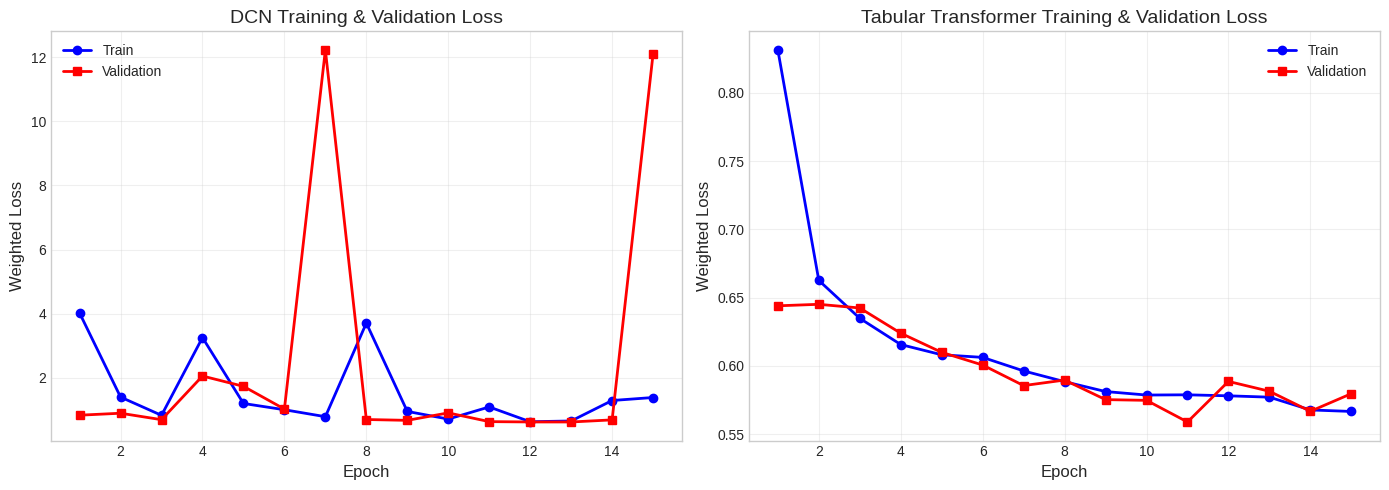

In [22]:
# Plot training and validation loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DCN loss
axes[0].plot(range(1, DCN_EPOCHS+1), dcn_train_losses, 'b-o', linewidth=2, markersize=6, label='Train')
axes[0].plot(range(1, DCN_EPOCHS+1), dcn_val_losses, 'r-s', linewidth=2, markersize=6, label='Validation')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Weighted Loss', fontsize=12)
axes[0].set_title('DCN Training & Validation Loss', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transformer loss
axes[1].plot(range(1, TRANSFORMER_EPOCHS+1), transformer_train_losses, 'b-o', linewidth=2, markersize=6, label='Train')
axes[1].plot(range(1, TRANSFORMER_EPOCHS+1), transformer_val_losses, 'r-s', linewidth=2, markersize=6, label='Validation')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Weighted Loss', fontsize=12)
axes[1].set_title('Tabular Transformer Training & Validation Loss', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

## 12. Model Comparison

In [23]:
# Create comparison DataFrame
comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision (Macro)': results['precision_macro'],
        'Recall (Macro)': results['recall_macro'],
        'F1-Score (Macro)': results['f1_macro'],
        'F1-Score (Weighted)': results['f1_weighted'],
        'ROC-AUC (OvR)': results['roc_auc_ovr'] if results['roc_auc_ovr'] else 0,
        'Training Time (s)': results['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score (Macro)', ascending=False)

print("="*80)
print("MODEL COMPARISON SUMMARY (With Class Weights)")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_model = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score (Macro)']
print(f"\nBest Model: {best_model} (F1-Score Macro: {best_f1:.4f})")

MODEL COMPARISON SUMMARY (With Class Weights)
              Model  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  F1-Score (Weighted)  ROC-AUC (OvR)  Training Time (s)
        Transformer  0.966359           0.726577        0.770929          0.737639             0.967490       0.995128         155.394633
                DCN  0.962777           0.709537        0.753900          0.712040             0.962701       0.994647          77.336390
Logistic Regression  0.948692           0.669671        0.732698          0.683447             0.950931       0.988013         115.028871
           AdaBoost  0.947278           0.682382        0.735986          0.681042             0.951808       0.981851          21.525251

Best Model: Transformer (F1-Score Macro: 0.7376)


## 13. Per-Class Performance

In [24]:
# Classification report for best model
best_model_name = comparison_df.iloc[0]['Model']
best_results = model_results[best_model_name]

print(f"\nClassification Report for Best Model: {best_model_name}")
print("="*70)
print(classification_report(y_test, best_results['y_pred'], target_names=CLASS_LABELS, zero_division=0))


Classification Report for Best Model: Transformer
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     19566
         DNS       0.35      0.37      0.36       734
        LDAP       0.56      0.36      0.44       669
       MSSQL       0.84      0.93      0.88      2947
         NTP       1.00      0.99      0.99     24274
     NetBIOS       0.51      0.78      0.62       248
     Portmap       0.17      0.38      0.24       137
        SNMP       0.48      0.77      0.59       543
         Syn       1.00      0.98      0.99      9875
        TFTP       1.00      0.99      1.00     19783
         UDP       0.92      0.96      0.94      5702
      UDPLag       0.89      0.75      0.82      1786

    accuracy                           0.97     86264
   macro avg       0.73      0.77      0.74     86264
weighted avg       0.97      0.97      0.97     86264



In [25]:
# Per-class F1-Score table
print("Per-Class F1-Score for Each Model:")
print("="*90)

f1_per_class_dict = {}
for model_name, results in model_results.items():
    f1_per_class_dict[model_name] = f1_score(y_test, results['y_pred'], average=None, zero_division=0)

f1_table = pd.DataFrame(f1_per_class_dict, index=CLASS_LABELS)
f1_table['Support'] = [np.sum(y_test == i) for i in range(N_CLASSES)]

cols = list(model_results.keys()) + ['Support']
f1_table = f1_table[cols]

print(f1_table.round(4).to_string())

# Summary statistics
print("\n" + "="*90)
print("Summary Statistics:")
print("-"*90)
for model_name in model_results.keys():
    f1_scores = f1_per_class_dict[model_name]
    print(f"{model_name}:")
    print(f"  Min F1:  {f1_scores.min():.4f} ({CLASS_LABELS[f1_scores.argmin()]})")
    print(f"  Max F1:  {f1_scores.max():.4f} ({CLASS_LABELS[f1_scores.argmax()]})")
    print(f"  Mean F1: {f1_scores.mean():.4f}")
    print()

Per-Class F1-Score for Each Model:
         Logistic Regression  AdaBoost     DCN  Transformer  Support
Benign                0.9861    0.9625  0.9930       0.9923    19566
DNS                   0.1148    0.2419  0.1805       0.3606      734
LDAP                  0.5898    0.6153  0.5386       0.4424      669
MSSQL                 0.8415    0.8860  0.8886       0.8784     2947
NTP                   0.9757    0.9841  0.9956       0.9927    24274
NetBIOS               0.3756    0.2674  0.3960       0.6178      248
Portmap               0.1826    0.0153  0.3518       0.2358      137
SNMP                  0.5014    0.5672  0.5833       0.5895      543
Syn                   0.9832    0.9831  0.9666       0.9917     9875
TFTP                  0.9940    0.9959  0.9960       0.9951    19783
UDP                   0.8613    0.8797  0.9372       0.9394     5702
UDPLag                0.7955    0.7741  0.7170       0.8159     1786

Summary Statistics:
-----------------------------------------------

In [26]:
# Detailed Per-Class F1-Score Summary with Weights
print("\nPer-Class F1-Score Summary:")
print("="*100)
print(f"{'Class':<12} {'Samples':>8} {'Weight':>8}", end="")
for model_name in model_results.keys():
    print(f" {model_name:>12}", end="")
print()
print("-"*100)

# Get test class counts
test_class_counts = np.bincount(y_test, minlength=N_CLASSES)

for i, label in enumerate(CLASS_LABELS):
    print(f"{label:<12} {test_class_counts[i]:>8,} {class_weights[i]:>8.2f}", end="")
    for model_name, results in model_results.items():
        f1_per_class = f1_score(y_test, results['y_pred'], average=None, zero_division=0)
        print(f" {f1_per_class[i]:>12.4f}", end="")
    print()


Per-Class F1-Score Summary:
Class         Samples   Weight Logistic Regression     AdaBoost          DCN  Transformer
----------------------------------------------------------------------------------------------------
Benign         19,566     0.37       0.9861       0.9625       0.9930       0.9923
DNS               734     9.80       0.1148       0.2419       0.1805       0.3606
LDAP              669    10.74       0.5898       0.6153       0.5386       0.4424
MSSQL           2,947     2.44       0.8415       0.8860       0.8886       0.8784
NTP            24,274     0.30       0.9757       0.9841       0.9956       0.9927
NetBIOS           248    28.94       0.3756       0.2674       0.3960       0.6178
Portmap           137    52.40       0.1826       0.0153       0.3518       0.2358
SNMP              543    13.23       0.5014       0.5672       0.5833       0.5895
Syn             9,875     0.73       0.9832       0.9831       0.9666       0.9917
TFTP           19,783     0.36   

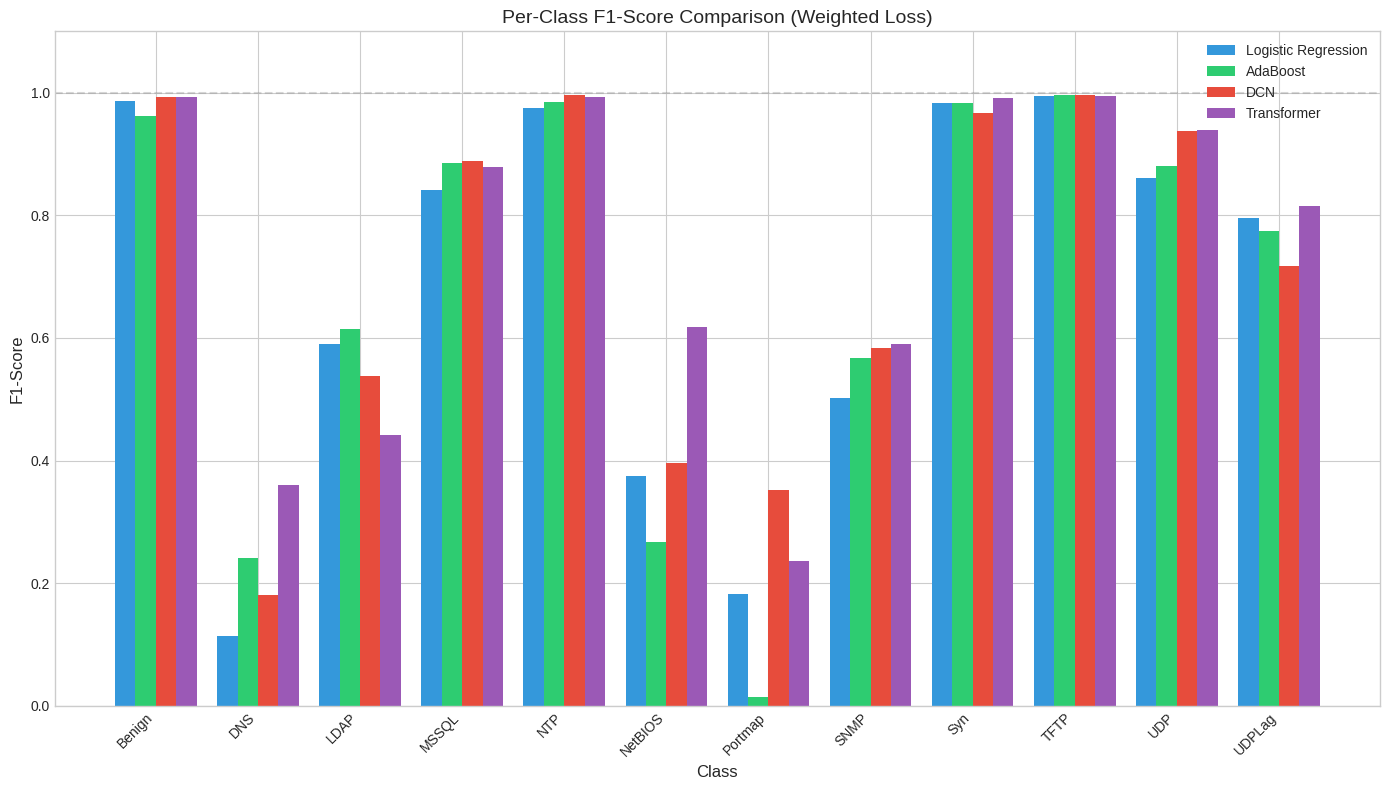

In [27]:
# Per-class F1-Score comparison bar chart
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(N_CLASSES)
width = 0.2
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, (model_name, results) in enumerate(model_results.items()):
    f1_per_class = f1_score(y_test, results['y_pred'], average=None, zero_division=0)
    ax.bar(x + i*width, f1_per_class, width, label=model_name, color=colors[i])

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison (Weighted Loss)', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(CLASS_LABELS, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'per_class_f1_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## 14. Confusion Matrices

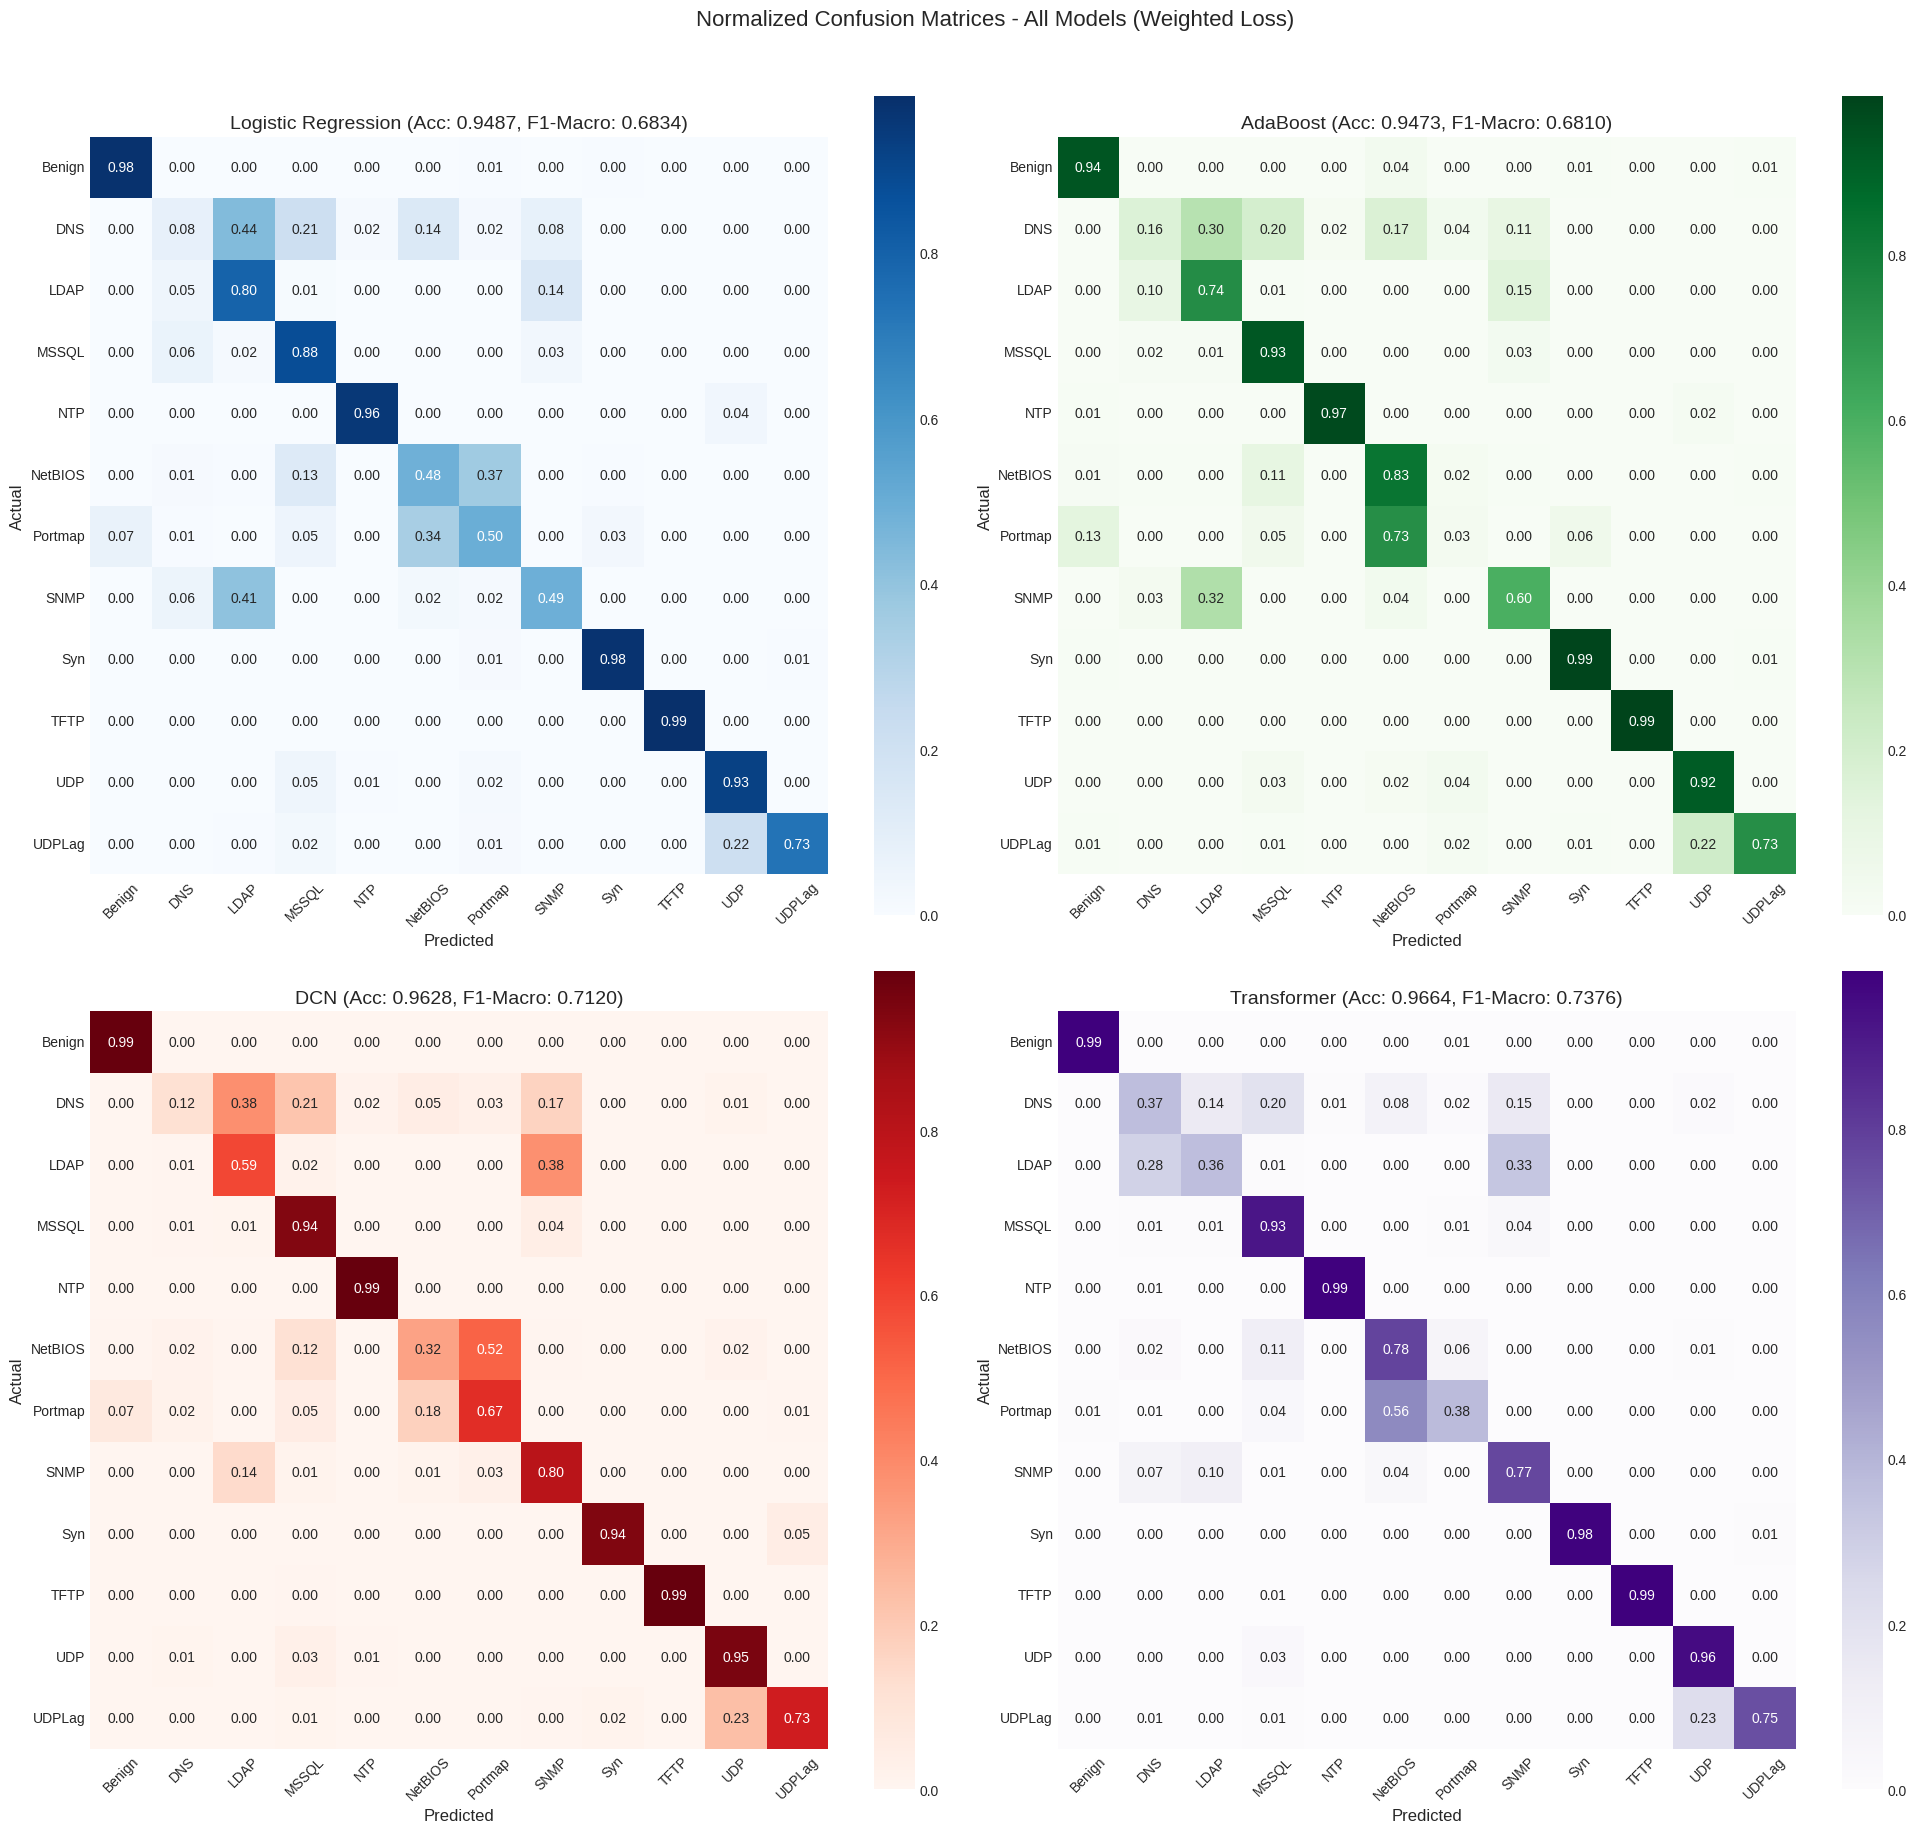

In [28]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

cmaps = ['Blues', 'Greens', 'Reds', 'Purples']

for i, (model_name, results) in enumerate(model_results.items()):
    ax = axes[i]
    cm = results['confusion_matrix']
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmaps[i], ax=ax,
                xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
                cbar=True, square=True)
    
    ax.set_title(f'{model_name} (Acc: {results["accuracy"]:.4f}, F1-Macro: {results["f1_macro"]:.4f})', fontsize=14)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle('Normalized Confusion Matrices - All Models (Weighted Loss)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

## 15. Save Test Predictions

In [29]:
# Create output DataFrame with predictions
test_output = test_df.copy()

# Add predictions from each model
test_output['label_encoded_logistic_regression'] = model_results['Logistic Regression']['y_pred']
test_output['label_encoded_adaboost'] = model_results['AdaBoost']['y_pred']
test_output['label_encoded_dcn'] = model_results['DCN']['y_pred']
test_output['label_encoded_transformer'] = model_results['Transformer']['y_pred']

# Save to output directory
output_path = os.path.join(OUTPUT_DIR, 'test_predictions.csv')
test_output.to_csv(output_path, index=False)

print("="*70)
print("PREDICTIONS SAVED")
print("="*70)
print(f"Output file: {output_path}")
print(f"Shape: {test_output.shape}")
print(f"\nNew columns added:")
print("  - label_encoded_logistic_regression")
print("  - label_encoded_adaboost")
print("  - label_encoded_dcn")
print("  - label_encoded_transformer")
print(f"\nFirst 10 rows of predictions:")
print(test_output[['label', 'label_encoded', 
                   'label_encoded_logistic_regression',
                   'label_encoded_adaboost', 
                   'label_encoded_dcn', 
                   'label_encoded_transformer']].head(10).to_string())

PREDICTIONS SAVED
Output file: /kaggle/working/test_predictions.csv
Shape: (86264, 58)

New columns added:
  - label_encoded_logistic_regression
  - label_encoded_adaboost
  - label_encoded_dcn
  - label_encoded_transformer

First 10 rows of predictions:
    label  label_encoded  label_encoded_logistic_regression  label_encoded_adaboost  label_encoded_dcn  label_encoded_transformer
0     UDP             10                                 10                      10                 10                         10
1  Benign              0                                  0                       0                  0                          0
2    TFTP              9                                  9                       9                  9                          9
3     Syn              8                                  8                       8                  8                          8
4  Benign              0                                  0                       0            

## 16. Final Summary

In [30]:
print("="*70)
print("EXPERIMENT COMPLETE (WITH CLASS WEIGHTS)")
print("="*70)

print(f"""
DATASET SUMMARY
{'-'*40}
Training samples:     {len(y_train):,}
Validation samples:   {len(y_val):,}
Test samples:         {len(y_test):,}
Features:             {n_features}
Classes:              {N_CLASSES}
Imbalance ratio:      {max(class_counts_array)/min(class_counts_array):.1f}x

PREPROCESSING
{'-'*40}
Scaling:              StandardScaler (for LR, DCN, Transformer)
AdaBoost:             Uses unscaled data

GPU CONFIGURATION
{'-'*40}
Device:               {device}
Number of GPUs:       {n_gpus}
Batch Size:           {BATCH_SIZE}
DCN Epochs:           {DCN_EPOCHS}
Transformer Epochs:   {TRANSFORMER_EPOCHS}

BEST MODEL
{'-'*40}
Model:                {best_model_name}
Accuracy:             {model_results[best_model_name]['accuracy']:.4f}
F1-Score (Macro):     {model_results[best_model_name]['f1_macro']:.4f}
F1-Score (Weighted):  {model_results[best_model_name]['f1_weighted']:.4f}
""")

print("\nFINAL RANKINGS (by F1-Score Macro):")
print("-"*40)
for idx, row in comparison_df.iterrows():
    rank = list(comparison_df.index).index(idx) + 1
    print(f"{rank}. {row['Model']:<20} F1-Macro: {row['F1-Score (Macro)']:.4f}  Acc: {row['Accuracy']:.4f}")

EXPERIMENT COMPLETE (WITH CLASS WEIGHTS)

DATASET SUMMARY
----------------------------------------
Training samples:     276,044
Validation samples:   69,012
Test samples:         86,264
Features:             52
Classes:              12
Imbalance ratio:      176.9x

PREPROCESSING
----------------------------------------
Scaling:              StandardScaler (for LR, DCN, Transformer)
AdaBoost:             Uses unscaled data

GPU CONFIGURATION
----------------------------------------
Device:               cuda
Number of GPUs:       2
Batch Size:           512
DCN Epochs:           15
Transformer Epochs:   15

BEST MODEL
----------------------------------------
Model:                Transformer
Accuracy:             0.9664
F1-Score (Macro):     0.7376
F1-Score (Weighted):  0.9675


FINAL RANKINGS (by F1-Score Macro):
----------------------------------------
1. Transformer          F1-Macro: 0.7376  Acc: 0.9664
2. DCN                  F1-Macro: 0.7120  Acc: 0.9628
3. Logistic Regression  F

In [31]:
# List saved files
print("\nSAVED FILES:")
print("="*70)
print(f"\nModels ({MODEL_DIR}):")
if SAVE_MODELS:
    for f in os.listdir(MODEL_DIR):
        fpath = os.path.join(MODEL_DIR, f)
        size = os.path.getsize(fpath) / 1024  # KB
        print(f"  - {f} ({size:.1f} KB)")

print(f"\nOutput files ({OUTPUT_DIR}):")
for f in os.listdir(OUTPUT_DIR):
    if f.endswith(('.csv', '.png')):
        fpath = os.path.join(OUTPUT_DIR, f)
        size = os.path.getsize(fpath) / 1024  # KB
        print(f"  - {f} ({size:.1f} KB)")


SAVED FILES:

Models (/kaggle/working/models):
  - logistic_regression.joblib (5.9 KB)
  - transformer.pt (1251.1 KB)
  - adaboost.joblib (29.8 KB)
  - scaler.joblib (1.8 KB)
  - dcn.pt (76.4 KB)

Output files (/kaggle/working):
  - confusion_matrices.png (468.2 KB)
  - test_predictions.csv (24747.8 KB)
  - training_curves.png (96.0 KB)
  - per_class_f1_comparison.png (77.0 KB)


## 17. Model Inference - Loading Saved Models

Demonstrating how to load each saved model and make predictions on a sample record.

In [ ]:
# ============================================
# Load and Inference: Logistic Regression
# ============================================

def load_and_predict_logistic_regression(model_path, scaler_path, sample_record):
    """
    Load saved Logistic Regression model and make prediction.
    
    Args:
        model_path: Path to saved .joblib model file
        scaler_path: Path to saved scaler .joblib file
        sample_record: numpy array of shape (n_features,) - raw features
    
    Returns:
        predicted_class: int
        predicted_label: str
        probabilities: array of shape (n_classes,)
    """
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Scale the input (LR requires scaled data)
    sample_scaled = scaler.transform(sample_record.reshape(1, -1))
    
    # Predict
    predicted_class = model.predict(sample_scaled)[0]
    probabilities = model.predict_proba(sample_scaled)[0]
    predicted_label = CLASS_LABELS[predicted_class]
    
    return predicted_class, predicted_label, probabilities

# Test on a sample from test set
sample_idx = 0
sample_record = X_test[sample_idx]
true_label = CLASS_LABELS[y_test[sample_idx]]

# Paths to saved model
saved_lr_model_path = os.path.join(MODEL_DIR, 'logistic_regression.joblib')
saved_scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')

# Make prediction
pred_class, pred_label, probs = load_and_predict_logistic_regression(
    saved_lr_model_path, saved_scaler_path, sample_record
)

print("="*60)
print("LOGISTIC REGRESSION - Inference Demo")
print("="*60)
print(f"Model Path: {saved_lr_model_path}")
print(f"Sample Index: {sample_idx}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Predicted Class: {pred_class}")
print(f"Confidence: {probs[pred_class]*100:.2f}%")
print(f"\nTop 3 Predictions:")
top3_idx = np.argsort(probs)[::-1][:3]
for idx in top3_idx:
    print(f"  {CLASS_LABELS[idx]:<10}: {probs[idx]*100:.2f}%")

In [ ]:
# ============================================
# Load and Inference: AdaBoost
# ============================================

def load_and_predict_adaboost(model_path, sample_record):
    """
    Load saved AdaBoost model and make prediction.
    
    Args:
        model_path: Path to saved .joblib model file
        sample_record: numpy array of shape (n_features,) - raw features (unscaled)
    
    Returns:
        predicted_class: int
        predicted_label: str
        probabilities: array of shape (n_classes,)
    """
    # Load model
    model = joblib.load(model_path)
    
    # AdaBoost uses UNSCALED data
    sample_input = sample_record.reshape(1, -1)
    
    # Predict
    predicted_class = model.predict(sample_input)[0]
    probabilities = model.predict_proba(sample_input)[0]
    predicted_label = CLASS_LABELS[predicted_class]
    
    return predicted_class, predicted_label, probabilities

# Test on a sample from test set
sample_idx = 1
sample_record = X_test[sample_idx]
true_label = CLASS_LABELS[y_test[sample_idx]]

# Path to saved model
saved_adaboost_model_path = os.path.join(MODEL_DIR, 'adaboost.joblib')

# Make prediction
pred_class, pred_label, probs = load_and_predict_adaboost(
    saved_adaboost_model_path, sample_record
)

print("="*60)
print("ADABOOST - Inference Demo")
print("="*60)
print(f"Model Path: {saved_adaboost_model_path}")
print(f"Sample Index: {sample_idx}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Predicted Class: {pred_class}")
print(f"Confidence: {probs[pred_class]*100:.2f}%")
print(f"\nTop 3 Predictions:")
top3_idx = np.argsort(probs)[::-1][:3]
for idx in top3_idx:
    print(f"  {CLASS_LABELS[idx]:<10}: {probs[idx]*100:.2f}%")

In [ ]:
# ============================================
# Load and Inference: DCN (Deep & Cross Network)
# ============================================

def load_and_predict_dcn(model_path, scaler_path, sample_record, device='cuda'):
    """
    Load saved DCN model and make prediction.
    
    Args:
        model_path: Path to saved .pt model file
        scaler_path: Path to saved scaler .joblib file
        sample_record: numpy array of shape (n_features,) - raw features
        device: 'cuda' or 'cpu'
    
    Returns:
        predicted_class: int
        predicted_label: str
        probabilities: array of shape (n_classes,)
    """
    # Load scaler
    scaler = joblib.load(scaler_path)
    
    # Load model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    n_features = checkpoint['n_features']
    n_classes = checkpoint['n_classes']
    
    # Recreate model architecture
    model = DCN(
        n_features=n_features,
        n_classes=n_classes,
        n_cross_layers=3,
        deep_layers=[128, 64, 32],
        dropout=0.1
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Scale and convert to tensor
    sample_scaled = scaler.transform(sample_record.reshape(1, -1))
    sample_tensor = torch.FloatTensor(sample_scaled).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(sample_tensor)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted_class = np.argmax(probabilities)
    
    predicted_label = CLASS_LABELS[predicted_class]
    
    return predicted_class, predicted_label, probabilities

# Test on a sample from test set
sample_idx = 2
sample_record = X_test[sample_idx]
true_label = CLASS_LABELS[y_test[sample_idx]]

# Paths to saved model
saved_dcn_model_path = os.path.join(MODEL_DIR, 'dcn.pt')
saved_scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')

# Make prediction
pred_class, pred_label, probs = load_and_predict_dcn(
    saved_dcn_model_path, saved_scaler_path, sample_record, device=device
)

print("="*60)
print("DCN (Deep & Cross Network) - Inference Demo")
print("="*60)
print(f"Model Path: {saved_dcn_model_path}")
print(f"Sample Index: {sample_idx}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Predicted Class: {pred_class}")
print(f"Confidence: {probs[pred_class]*100:.2f}%")
print(f"\nTop 3 Predictions:")
top3_idx = np.argsort(probs)[::-1][:3]
for idx in top3_idx:
    print(f"  {CLASS_LABELS[idx]:<10}: {probs[idx]*100:.2f}%")

In [ ]:
# ============================================
# Load and Inference: Tabular Transformer
# ============================================

def load_and_predict_transformer(model_path, scaler_path, sample_record, device='cuda'):
    """
    Load saved Tabular Transformer model and make prediction.
    
    Args:
        model_path: Path to saved .pt model file
        scaler_path: Path to saved scaler .joblib file
        sample_record: numpy array of shape (n_features,) - raw features
        device: 'cuda' or 'cpu'
    
    Returns:
        predicted_class: int
        predicted_label: str
        probabilities: array of shape (n_classes,)
    """
    # Load scaler
    scaler = joblib.load(scaler_path)
    
    # Load model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    n_features = checkpoint['n_features']
    n_classes = checkpoint['n_classes']
    
    # Recreate model architecture
    model = TabularTransformer(
        n_features=n_features,
        n_classes=n_classes,
        d_model=64,
        nhead=4,
        num_layers=2,
        dropout=0.1
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Scale and convert to tensor
    sample_scaled = scaler.transform(sample_record.reshape(1, -1))
    sample_tensor = torch.FloatTensor(sample_scaled).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(sample_tensor)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted_class = np.argmax(probabilities)
    
    predicted_label = CLASS_LABELS[predicted_class]
    
    return predicted_class, predicted_label, probabilities

# Test on a sample from test set
sample_idx = 3
sample_record = X_test[sample_idx]
true_label = CLASS_LABELS[y_test[sample_idx]]

# Paths to saved model
saved_transformer_model_path = os.path.join(MODEL_DIR, 'transformer.pt')
saved_scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')

# Make prediction
pred_class, pred_label, probs = load_and_predict_transformer(
    saved_transformer_model_path, saved_scaler_path, sample_record, device=device
)

print("="*60)
print("TABULAR TRANSFORMER - Inference Demo")
print("="*60)
print(f"Model Path: {saved_transformer_model_path}")
print(f"Sample Index: {sample_idx}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Predicted Class: {pred_class}")
print(f"Confidence: {probs[pred_class]*100:.2f}%")
print(f"\nTop 3 Predictions:")
top3_idx = np.argsort(probs)[::-1][:3]
for idx in top3_idx:
    print(f"  {CLASS_LABELS[idx]:<10}: {probs[idx]*100:.2f}%")